In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ConvNeXtBase, ConvNeXtXLarge
from tensorflow.keras.layers import GlobalAveragePooling2D

In [2]:
train_dir = '/Users/davemag9/Desktop/Diploma/archive1/Indian Food Images/Indian Food Images'

train_dir = '/Users/davemag9/Desktop/Diploma/food20dataset/train_set'
subdirectories = [os.path.join(train_dir, d) for d in os.listdir(train_dir) if
                  os.path.isdir(os.path.join(train_dir, d))]
subdirectories

['/Users/davemag9/Desktop/Diploma/food20dataset/train_set/vada pav',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/idly',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/bisibelebath',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/samosa',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/paniyaram',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/meduvadai',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/ven pongal',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/dhokla',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/chaat',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/poori',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/dosa',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/gulab jamun',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/chappati',
 '/Users/davemag9/Desktop/Diploma/food20dataset/train_set/biriyani',
 '/Users/davemag9/Desktop/Diploma/food20d

In [3]:
categories = sorted(os.listdir(train_dir))
categories = [category for category in categories if category != '.DS_Store']

categories

['biriyani',
 'bisibelebath',
 'butternaan',
 'chaat',
 'chappati',
 'dhokla',
 'dosa',
 'gulab jamun',
 'halwa',
 'idly',
 'kathi roll',
 'meduvadai',
 'noodles',
 'paniyaram',
 'poori',
 'samosa',
 'tandoori chicken',
 'upma',
 'vada pav',
 'ven pongal']

In [4]:
df = pd.DataFrame(columns=['image_path', 'label'])
df

,image_path,label


In [5]:
dfs = []

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

In [6]:
dfs = []
max_images_per_category = 600

for category in categories:
    category_path = os.path.join(train_dir, category)
    image_data = []
    count = 0
    for image_name in os.listdir(category_path):
        if count >= max_images_per_category:
            break
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
        count += 1
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

In [7]:
df = pd.concat(dfs, ignore_index=True)
df

,image_path,label
0,/Users/davemag9/Desktop/Diploma/food20dataset/...,biriyani
1,/Users/davemag9/Desktop/Diploma/food20dataset/...,biriyani
2,/Users/davemag9/Desktop/Diploma/food20dataset/...,biriyani
3,/Users/davemag9/Desktop/Diploma/food20dataset/...,biriyani
4,/Users/davemag9/Desktop/Diploma/food20dataset/...,biriyani
...,...,...
1395,/Users/davemag9/Desktop/Diploma/food20dataset/...,ven pongal
1396,/Users/davemag9/Desktop/Diploma/food20dataset/...,ven pongal
1397,/Users/davemag9/Desktop/Diploma/food20dataset/...,ven pongal
1398,/Users/davemag9/Desktop/Diploma/food20dataset/...,ven pongal


In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
train_df.shape

(1120, 2)

In [10]:
val_df.shape

(280, 2)

In [11]:
# val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, shuffle=True)

In [12]:
val_df.shape

(280, 2)

In [13]:
# test_df.shape

In [14]:
augmentation_params = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'shear_range': 0.2,
    'zoom_range': 0.1,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}
img_size = (224, 224)
batch_size = 32

In [15]:
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    **augmentation_params
)
val_datagen = ImageDataGenerator(
    # rescale=1. / 255
)
# test_datagen = ImageDataGenerator(
#     rescale=1. / 255
# )

In [16]:
train_images = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=True,
    seed=42,
    class_mode='categorical'
)

Found 1120 validated image filenames belonging to 20 classes.


In [17]:
val_images = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=False,
    seed=42,
    class_mode='categorical'
)

Found 280 validated image filenames belonging to 20 classes.


In [18]:
# test_images = test_datagen.flow_from_dataframe(
#     test_df,
#     x_col='image_path',
#     y_col='label',
#
#     target_size=img_size,
#     batch_size=batch_size,
#
#     shuffle=False,
#     seed=42,
#     class_mode='categorical'
# )

In [19]:
pretrained_model = EfficientNetB0(
    input_shape=(img_size[0], img_size[1], 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

outputs = Dense(len(categories), activation='softmax')(pretrained_model.output)

model_en = Model(pretrained_model.input, outputs, name='EfficientNetB0')

# print(model_en.summary())


In [20]:
model_en.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
history_mn = model_en.fit(
    train_images,
    validation_data=val_images,
    epochs=5,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9383 - loss: 0.3342 - val_accuracy: 0.8286 - val_loss: 0.6275
Epoch 2/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9644 - loss: 0.2850 - val_accuracy: 0.8321 - val_loss: 0.6182
Epoch 3/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9703 - loss: 0.2452 - val_accuracy: 0.8286 - val_loss: 0.6138
Epoch 4/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9667 - loss: 0.2375 - val_accuracy: 0.8286 - val_loss: 0.6091
Epoch 5/5
35/35 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9605 - loss: 0.2280 - val_accuracy: 0.8321 - val_loss: 0.6074


In [39]:
test_dir = '/Users/davemag9/Desktop/Diploma/food20dataset/test_set'
subdirectories = [os.path.join(train_dir, d) for d in os.listdir(test_dir) if
                  os.path.isdir(os.path.join(test_dir, d))]

categories = sorted(os.listdir(test_dir))
categories = [category for category in categories if category != '.DS_Store']


df = pd.DataFrame(columns=['image_path', 'label'])

dfs = []

for category in categories:
    category_path = os.path.join(test_dir, category)
    image_data = []
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)


dfs = []
max_images_per_category = 600

for category in categories:
    category_path = os.path.join(test_dir, category)
    image_data = []
    count = 0
    for image_name in os.listdir(category_path):
        if count >= max_images_per_category:
            break
        image_path = os.path.join(category_path, image_name)
        image_data.append({'image_path': image_path, 'label': category})
        count += 1
    df_category = pd.DataFrame(image_data)
    dfs.append(df_category)

test_df = pd.concat(dfs, ignore_index=True)


test_datagen = ImageDataGenerator(
    # rescale=1. / 255
)

test_images = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',

    target_size=img_size,
    batch_size=batch_size,

    shuffle=False,
    seed=42,
    class_mode='categorical'
)

Found 600 validated image filenames belonging to 20 classes.


In [40]:
predictions = model_en.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

predicted_classes[:80]

/Users/davemag9/Desktop/Diploma/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 967ms/step


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,  0,  0,  0,  0,  0, 16,
        0,  0,  0,  5,  0,  0,  0,  0,  3,  0,  0,  0, 17,  1,  1,  1, 19,
        1,  1,  1, 17,  8,  1,  3,  8, 19,  1, 17,  8,  1,  8,  1,  1,  1,
        8,  1,  8,  8,  8,  1,  1,  1,  8,  2,  2,  4,  2,  2,  2,  2, 16,
        5,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [41]:
true_classes = test_images.classes
class_labels = list(val_images.class_indices.keys())
num_images = 25
count = 0

while count < num_images:
    print(f"{count + 1}. Label: {true_classes[count]}, Prediction: {predicted_classes[count]}")
    count += 1

1. Label: 0, Prediction: 0
2. Label: 0, Prediction: 0
3. Label: 0, Prediction: 0
4. Label: 0, Prediction: 0
5. Label: 0, Prediction: 0
6. Label: 0, Prediction: 0
7. Label: 0, Prediction: 0
8. Label: 0, Prediction: 0
9. Label: 0, Prediction: 0
10. Label: 0, Prediction: 6
11. Label: 0, Prediction: 0
12. Label: 0, Prediction: 0
13. Label: 0, Prediction: 0
14. Label: 0, Prediction: 0
15. Label: 0, Prediction: 0
16. Label: 0, Prediction: 0
17. Label: 0, Prediction: 16
18. Label: 0, Prediction: 0
19. Label: 0, Prediction: 0
20. Label: 0, Prediction: 0
21. Label: 0, Prediction: 5
22. Label: 0, Prediction: 0
23. Label: 0, Prediction: 0
24. Label: 0, Prediction: 0
25. Label: 0, Prediction: 0


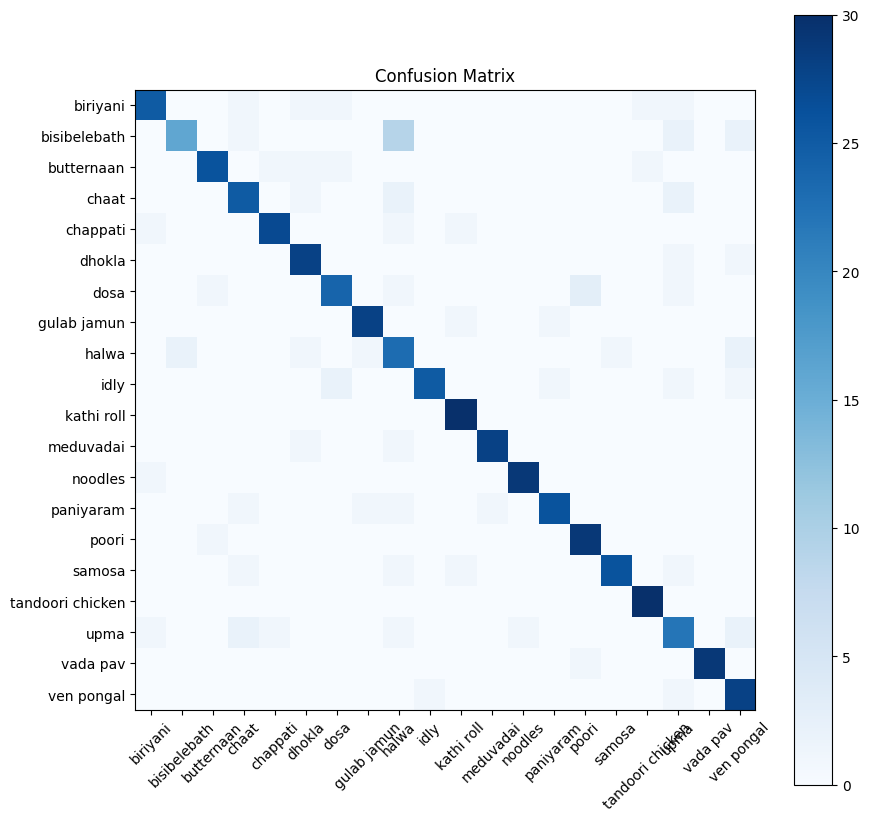

In [42]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.show()

In [43]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

print(report)

                  precision    recall  f1-score   support

        biriyani       0.89      0.83      0.86        30
    bisibelebath       0.89      0.53      0.67        30
      butternaan       0.93      0.87      0.90        30
           chaat       0.81      0.83      0.82        30
        chappati       0.93      0.90      0.92        30
          dhokla       0.85      0.93      0.89        30
            dosa       0.86      0.80      0.83        30
     gulab jamun       0.93      0.93      0.93        30
           halwa       0.57      0.77      0.66        30
            idly       0.96      0.83      0.89        30
      kathi roll       0.91      1.00      0.95        30
       meduvadai       0.97      0.93      0.95        30
         noodles       0.97      0.97      0.97        30
       paniyaram       0.93      0.87      0.90        30
           poori       0.88      0.97      0.92        30
          samosa       0.96      0.87      0.91        30
tandoori chic